# Project: Arabic poetry classification
# Abstract
### An attempt is made to classify  Arabic poets. The dataset consist of 58021 poets that will be classified into five different groups (العصر العباسي,العصر الأندلسي , العصر الإسلامي, العصر الجاهلي, العصر الحديث). In this project, I will understand the data and try to provide a solution for how to classify Arabic poets.

#  0. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import nltk
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from tqdm import tqdm as tq
import csv

import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics  import classification_report, accuracy_score, f1_score,precision_score,recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import svm

%matplotlib inline

# 1. Load the dataset.

In [2]:
fields = ['poem_id', 'poem_style','poem_text','poem_title','poet_cat','poet_id','poet_name']

poem = pd.read_csv('Arabic Poetry Dataset/all_poems_58K.csv',usecols=fields,encoding='utf-8') 
poem.head()


,poem_id,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_name
0,21,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,بدر شاكر السياب
1,65546,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,بدر شاكر السياب
2,65561,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,2,بدر شاكر السياب
3,65554,فصحى,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,أساطير,العراق,2,بدر شاكر السياب
4,65550,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,اللقاء الأخير,العراق,2,بدر شاكر السياب


# 2. EDA.

### print number of rows and columns

In [3]:
poem.shape

(58021, 7)

### Print the full summary

In [4]:
poem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58021 entries, 0 to 58020
Data columns (total 7 columns):
poem_id       58021 non-null int64
poem_style    58021 non-null object
poem_text     58020 non-null object
poem_title    58021 non-null object
poet_cat      58021 non-null object
poet_id       58021 non-null int64
poet_name     58021 non-null object
dtypes: int64(2), object(5)
memory usage: 3.1+ MB


It seems that there is a null value in poem_text

In [5]:
poem.isna().sum()

poem_id       0
poem_style    0
poem_text     1
poem_title    0
poet_cat      0
poet_id       0
poet_name     0
dtype: int64

#### Returning the index of the null value

In [6]:
poem[poem['poem_text'].isnull()].index.tolist()

[2454]

#### Displaying the null value

In [7]:
poem.iloc[2454]

poem_id            6200
poem_style         فصحى
poem_text           NaN
poem_title     الأشباح 
poet_cat        البحرين
poet_id              68
poet_name     قاسم حداد
Name: 2454, dtype: object

#### Let's drop the null value

In [8]:
poem = poem.dropna(axis=0, subset=['poem_text'])

In [9]:
poem[poem['poem_text'].isnull()].index.tolist()

[]

#### View the unique categories

In [10]:
poem.poet_cat.unique()

array(['العراق', 'سوريا', 'مصر', 'تونس', 'السعودية', 'لبنان', 'فلسطين',
       'اليمن', 'العصر الجاهلي', 'العصر الأندلسي', 'السودان', 'البحرين',
       'العصر الإسلامي', 'العصر العباسي', 'ليبيا', 'عمان', 'المغرب',
       'الجزائر', 'الإمارات', 'الأردن', 'الكويت', 'قطر', 'موريتانيا',
       'شعراء العراق والشام', 'أفغانستان', 'إيران'], dtype=object)

### It seem that we have (العصر العباسي,العصر الأندلسي , العصر الإسلامي, العصر الجاهلي, وأسماء دول  ), the country names will be converted into العصر الحديث.

### If there is any duplicate poem, remove it.

In [11]:
poem.drop_duplicates(subset='poem_text', inplace=True)

In [12]:
poem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57693 entries, 0 to 58020
Data columns (total 7 columns):
poem_id       57693 non-null int64
poem_style    57693 non-null object
poem_text     57693 non-null object
poem_title    57693 non-null object
poet_cat      57693 non-null object
poet_id       57693 non-null int64
poet_name     57693 non-null object
dtypes: int64(2), object(5)
memory usage: 3.5+ MB


##### The poem number reduced from 58020 to 57693 after removing the dublicated poems

### Now, let's view one poem, to check for any special character

In [13]:
poem.poem_text.iloc[1]

' انا لا ازال و في يدي قدحي ياليل اين تفرق الشرب ما زلت اشربها و اشربها حتي ترنح افقك الرحب الشرق عفر بالضباب فما يبدو فاين سناك يا غرب ما لنجوم غرقن من سام في ضوءهن و كادت الشهب انا لا ازال و في يدي قدحي ياليل اين تفرق الشرب ****** الحان بالشهوات مصطخب حتي يكاد بهن ينهار و كان مصاحبيه من ضرج كفان مدهما لي العار كفان بل ثغران قد صبغا بدم تدفق منه تيار كاسان ملءهما طلي عصرت من مهجتين رماهما الحب او مخلبان عليهما مزق حمراء تزعم انها قلب ****** الخمر جمعت الدهور , ومافيهن بين جوانب الحان ياويحها اسكرت ام سكرتام نحن في السكرات سيان رمت العوالم والدهور علي ثغري وفوق يدي واجفاني كفي تمد فما تناولني كاسا لعيني خمرها نهب واصافح الدنيا فياعجبا البعد لان واعرض القرب ****** يا ليل اين تطوف بي قدمي في اي منعرج من الظلم تلك السبيل اكاد اعرفها بالامس خاصر طيفها حلمي هي غمد خنجرك الرهيب و قد جردته و مسحت عنه دمي تلك السبيل علي جوانبها تمزق الخطوات او تكبو تثاءب الاجساد جاءعة فيها كما يتثاءب الذءب حسناء يلهب عريها ظماي فاكاد اشرب ذلك العريا و اكاد احطمه فتحطمني عينان جاءعتان كالدنيا غرست يد الحمي علي 

### Let's remove any special character and numbers form the poems

In [14]:
arabic_punctuations = '''`÷×-؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
numbers = '،؛؟”0123456789“'

punctuations_list = arabic_punctuations + numbers
def removePunctuation(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

poem['poem_text'] = poem['poem_text'].apply(lambda x: removePunctuation(x))

In [15]:
poem.head()

,poem_id,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_name
0,21,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,بدر شاكر السياب
1,65546,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,بدر شاكر السياب
2,65561,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,2,بدر شاكر السياب
3,65554,فصحى,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,أساطير,العراق,2,بدر شاكر السياب
4,65550,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,اللقاء الأخير,العراق,2,بدر شاكر السياب


# 3. NLP Techniques.
### Now, it is time to perform tokenization (chopping a character into pieces)

In [16]:
poem["poem_text"] = poem["poem_text"].apply(nltk.word_tokenize)

In [17]:
poem.head()

,poem_id,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_name
0,21,فصحى,"[عيناك, غابتا, نخيل, ساعة, السحر, او, شرفتان, ...",أنشودة المطر,العراق,2,بدر شاكر السياب
1,65546,فصحى,"[انا, لا, ازال, و, في, يدي, قدحي, ياليل, اين, ...",أقداح و أحلام,العراق,2,بدر شاكر السياب
2,65561,فصحى,"[علي, مقلتيك, ارتشفت, النجوم, وعانقت, امالي, ا...",هوى واحد !,العراق,2,بدر شاكر السياب
3,65554,فصحى,"[اساطير, من, حشرجات, الزمان, نسيج, اليد, البال...",أساطير,العراق,2,بدر شاكر السياب
4,65550,فصحى,"[والتف, حولك, ساعداي, ومال, جيدك, في, اشتهاء, ...",اللقاء الأخير,العراق,2,بدر شاكر السياب


In [18]:
poem.shape

(57693, 7)

In [19]:
poem['poem_text']

0        [عيناك, غابتا, نخيل, ساعة, السحر, او, شرفتان, ...
1        [انا, لا, ازال, و, في, يدي, قدحي, ياليل, اين, ...
2        [علي, مقلتيك, ارتشفت, النجوم, وعانقت, امالي, ا...
3        [اساطير, من, حشرجات, الزمان, نسيج, اليد, البال...
4        [والتف, حولك, ساعداي, ومال, جيدك, في, اشتهاء, ...
5        [اطلي, علي, طرفي, الدامع, خيالا, من, الكوكب, ا...
6        [اتبعيني, فالضحي, رانت, به, الذكري, علي, شط, ب...
7        [الداء, يثلج, راحتي, ويطفء, الغد, في, خيالي, و...
8        [سوف, امضي, اسمع, الريح, تناديني, بعيدا, في, ظ...
9        [اليل, والسوق, القديم, خفت, به, الاصوات, الا, ...
10       [هبت, تغمغم, سوف, نفترق, روح, علي, شفتيك, تحتر...
11       [بقايا, من, القافلة, تنير, لها, نجمة, افلة, طر...
12       [لك, الحمد, مهما, استطال, البلاء, ومهما, استبد...
13       [اريقي, علي, ساعدي, الدموع, و, شدي, علي, صدري,...
14       [لا, تزيديه, لوعة, فهو, يلقاك, لينسي, لديك, بع...
15       [عطرت, احلامي, بهذا, الشذي, من, شعرك, المسترسل...
16       [عينان, زرقاوان, ينعس, فيهما, لون, الغدير, ارن.

### Next step is to remove Arabic stop words

In [20]:
stop = stopwords.words('arabic')
poem['poem_text'] = poem['poem_text'].apply(lambda x: [word for word in tq(x) if word not in stop])

clear_output() #Clear the output

### Last step, (Stemming) bring the words back to their root

In [21]:
ISRIS_st = ISRIStemmer()
poem['poem_text'] = poem['poem_text'].apply(lambda x: [ISRIS_st.stem(word) for word in tq(x)])

clear_output()

### This step is to save the tokenized and stemmed data, so later it can be read as a list to feed it to TfidfVectorizer

In [22]:
poem.to_csv('token_stem.csv', encoding='utf-8')

In [23]:
poem = pd.read_csv('token_stem.csv') 

In [24]:
poem['poem_text'].head()    

0    ['عين', 'غبت', 'نخل', 'سعة', 'سحر', 'او', 'شرف...
1    ['انا', 'ازل', 'و', 'يدي', 'قدح', 'الل', 'اين'...
2    ['علي', 'قلت', 'رشف', 'نجم', 'عنق', 'ملي', 'اي...
3    ['اطر', 'حشرج', 'زمن', 'نسج', 'الد', 'بلي', 'ر...
4    ['لتف', 'حول', 'سعد', 'ومل', 'جيد', 'شهء', 'زه...
Name: poem_text, dtype: object

# 4. Visualization.
### Count the poets category

In [25]:
poem['poet_cat'].value_counts()

العصر العباسي          19400
العصر الأندلسي          6292
سوريا                   5031
مصر                     4770
لبنان                   4584
العراق                  4226
العصر الإسلامي          3696
السعودية                1928
فلسطين                  1710
العصر الجاهلي           1457
اليمن                    698
عمان                     607
الإمارات                 563
البحرين                  551
الجزائر                  405
السودان                  403
تونس                     351
الأردن                   263
ليبيا                    238
المغرب                   201
إيران                     90
أفغانستان                 70
شعراء العراق والشام       68
الكويت                    54
قطر                       22
موريتانيا                 15
Name: poet_cat, dtype: int64

The categories are (العصر العباسي,العصر الأندلسي , العصر الإسلامي, العصر الجاهلي, وأسماء دول), أسماء الدول will be converted into العصر الحديث

### Now create a list of moden and old categories, to group all country names into one category.

In [26]:
modern= ['سوريا','مصر','لبنان','العراق','السعودية','فلسطين','اليمن','عمان'
         ,'الإمارات','البحرين','الجزائر','السودان','تونس','الأردن','ليبيا',
        'المغرب','إيران','أفغانستان','شعراء العراق والشام','الكويت','قطر','موريتانيا']
old = ['العصر العباسي','العصر الأندلسي','العصر الإسلامي','العصر الجاهلي']

In [27]:
poem['category'] = poem['poet_cat']

poem['category'] = poem['category'].replace(old[0], 1)
poem['category'] = poem['category'].replace(old[1], 2)
poem['category'] = poem['category'].replace(old[2], 3)
poem['category'] = poem['category'].replace(old[3], 4)
poem['category'] = poem['category'].replace(modern, 5) # العصر الحديث

In [28]:
poem['category']
poem['category'].value_counts()

5    26848
1    19400
2     6292
3     3696
4     1457
Name: category, dtype: int64

The most Frequent category is العصر الحديث with 26848 poem

### Visualize the count of categories

Text(0, 0.5, 'Letters')

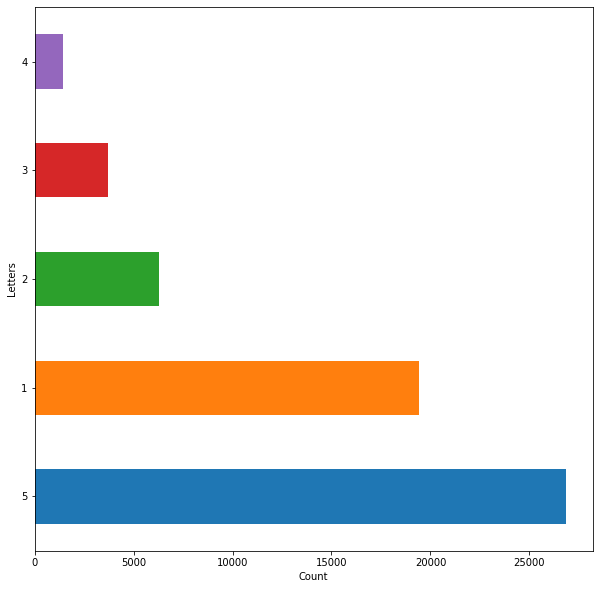

In [29]:
poem['category'].value_counts().plot(kind='barh', figsize=(10,10))
plt.xlabel('Count')
plt.ylabel('Letters')

# 5. split the data into training and testingn (consider only poem and category).

In [30]:
x_train, y_test, x_label, y_label = train_test_split(poem['poem_text'], poem['category'], test_size=0.2, random_state=42)

# 6. Now create a matrix of TF-IDF features. Set the max_features to 1000, if not then 6032543 features will be considerd, to reduce computational cost set it to 1000.

In [31]:
tf = TfidfVectorizer(max_features=1000,ngram_range=(1, 2),min_df=0)

tfidf_matrix = tf.fit_transform(poem['poem_text'])

trainTfidf = tf.transform(x_train)
testtfidf = tf.transform(y_test)

In [32]:
tfidf_matrix.shape

(57693, 1000)

# 7. Trying different models to see which one is better.

### First one to use is Logistic Regression.

In [33]:
logClassifier = LogisticRegression(solver='sag', C=10,penalty='l2')
logClassifier.fit(trainTfidf, x_label)
logPredictions = logClassifier.predict(testtfidf)

print("accuracy :",metrics.accuracy_score(y_label,logPredictions))
print("macro f1 score :",metrics.f1_score(y_label, logPredictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_label, logPredictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_label,logPredictions))
print("Precision recall report :\n",metrics.classification_report(y_label, logPredictions))

accuracy : 0.7062137100268654
macro f1 score : 0.4902782883294406
micro f1 scoore : 0.7062137100268654
hamming loss : 0.2937862899731346
Precision recall report :
               precision    recall  f1-score   support

           1       0.62      0.77      0.69      3821
           2       0.55      0.24      0.34      1229
           3       0.57      0.31      0.40       748
           4       0.42      0.13      0.20       295
           5       0.81      0.85      0.83      5446

    accuracy                           0.71     11539
   macro avg       0.59      0.46      0.49     11539
weighted avg       0.69      0.71      0.69     11539



#### lets use Kfold cross validation on Logistic Regression to see if there is any improvement.

In [34]:
logKfold = cross_val_score(logClassifier, trainTfidf, x_label, cv=10)
print(logKfold)

[0.70333478 0.70116934 0.70233969 0.69729144 0.70292524 0.7035753
 0.69274106 0.70119177 0.70351105 0.70388034]


After using Kfold the results are almost the same, no improvements.

### Stochastic Gradient Descent Classifier been successfully applied to large-scale of machine learning problems, often encountered in text classification and NLP, so I decided to use it.

In [35]:
classifier = SGDClassifier(loss='log', alpha=0.00001, penalty='l1', verbose=0)
classifier.fit(trainTfidf, x_label)
predictions = classifier.predict(testtfidf)

print("accuracy :",metrics.accuracy_score(y_label,predictions))
print("macro f1 score :",metrics.f1_score(y_label, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_label, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_label,predictions))
print("Precision recall report :\n",metrics.classification_report(y_label, predictions))

accuracy : 0.7055204090475777
macro f1 score : 0.47697596876421217
micro f1 scoore : 0.7055204090475777
hamming loss : 0.2944795909524222
Precision recall report :
               precision    recall  f1-score   support

           1       0.61      0.78      0.69      3821
           2       0.56      0.22      0.31      1229
           3       0.59      0.30      0.40       748
           4       0.41      0.09      0.15       295
           5       0.81      0.85      0.83      5446

    accuracy                           0.71     11539
   macro avg       0.60      0.45      0.48     11539
weighted avg       0.69      0.71      0.68     11539



SGD classifier perfomded almosl as good as logistic regression

### Another classifier to compare with is Gaussian Naive Bayes.

In [36]:
nbClassifier = GaussianNB()
nbscore=nbClassifier.fit(trainTfidf.toarray(), x_label)
nbPredictions = nbClassifier.predict(testtfidf.toarray())

print("accuracy :",metrics.accuracy_score(y_label,nbPredictions))
print("macro f1 score :",metrics.f1_score(y_label, nbPredictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_label, nbPredictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_label,nbPredictions))
print("Precision recall report :\n",metrics.classification_report(y_label, nbPredictions))

accuracy : 0.5254354796776151
macro f1 score : 0.4095579549096639
micro f1 scoore : 0.5254354796776151
hamming loss : 0.47456452032238494
Precision recall report :
               precision    recall  f1-score   support

           1       0.59      0.35      0.44      3821
           2       0.27      0.55      0.36      1229
           3       0.22      0.43      0.29       748
           4       0.12      0.54      0.20       295
           5       0.89      0.65      0.75      5446

    accuracy                           0.53     11539
   macro avg       0.42      0.50      0.41     11539
weighted avg       0.66      0.53      0.56     11539



Gaussian naive bayes did not perfom well as compared to the previos models

### Last one to compare with is K nearest neighbors, let's choose different values of K to see what fits better.

accuracy : 0.6096715486610624
macro f1 score : 0.32727255253248055
micro f1 scoore : 0.6096715486610624
hamming loss : 0.3903284513389375
Precision recall report :
               precision    recall  f1-score   support

           1       0.47      0.91      0.62      3821
           2       0.81      0.05      0.10      1229
           3       0.62      0.10      0.17       748
           4       0.25      0.01      0.01       295
           5       0.87      0.62      0.73      5446

    accuracy                           0.61     11539
   macro avg       0.60      0.34      0.33     11539
weighted avg       0.70      0.61      0.57     11539



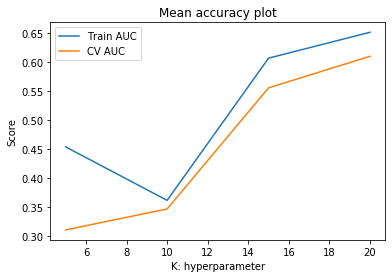

In [37]:
k = [5,10,15,20]
BOW_Train_Accuracy = []
BOW_CV_Accuracy = []
for i in k:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(trainTfidf,x_label)
    BOW_Train_Accuracy.append(model.score(trainTfidf,x_label))
    BOW_CV_Accuracy.append(model.score(testtfidf,y_label))

knn=model.predict(testtfidf)
print("accuracy :",metrics.accuracy_score(y_label,knn))
print("macro f1 score :",metrics.f1_score(y_label, knn, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_label, knn, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_label,knn))
print("Precision recall report :\n",metrics.classification_report(y_label, knn))

plt.plot(np.asarray(k), BOW_Train_Accuracy, label='Train AUC')
plt.plot(np.asarray(k), BOW_CV_Accuracy, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("Score")
plt.title("Mean accuracy plot")
plt.show()

It seems that 20 K is better for KNN, however the accuracy is not that good.

# 8.Conclusion.
### In this project, a classification model was built to classify Arabic poets using different models. As we see above, logostic regression and SGD performed better than the others, to get a better accuracy it is possible to change hyperparameter values and try different models, this can result even in choosing a better model.
